# A Tutorial of the $\texttt{pykepmask}$ Package

## Overview

Welcome to the interactive tutorial of the $\texttt{pykepmask}$ package!

$\texttt{pykepmask}$ can be used to generate Keplerian masks.  These masks are useful for extracting molecular line emission (e.g., C$^{18}$O emission) in disks undergoing Keplerian rotation around host stars.  Protoplanetary disks are a great example of such disks (e.g., the infamous disk TW Hya), and are what this package was originally designed for.

Let's go ahead and get started!

## Outline

Here's everything that we'll be covering in this tutorial:
1. Package Installation
1. Package Use: the KepMask class
    1. Loading in and accessing disk parameters
    1. Generating Keplerian masks for an (ALMA) image cube
    1. Accessing and plotting masked image products (e.g., mom0s and spectra)
    1. Masks with hyperfine structure


## Package Installation

The full package can be found in the *pykepmask* folder on the GitHub page: (https://github.com/jpegues/kepmask).  Download the *pykepmask* folder somewhere are your computer.

Since *pykepmask* isn't an official Python package (at least, not at the moment), it can't be installed via the fancy Python **pip-install** procedure.  So you will have to add the location of the *pykepmask* folder to your Python PATH.  There are different ways to do this, but here we'll use the Python $\texttt{sys}$ package to do so:

In [1]:
#Import the sys package
import sys

#Add the location of the pykepmask folder to the Python PATH
filepath = "/usr/path/to/folder" #Path to pykepmask folder; you should change this to point to your downloaded pykepmask folder
sys.path.insert(1, filepath)

Now, we can import the $\texttt{pykepmask}$ package:

In [2]:
import pykepmask

If this gives an error, check that you set the value for the variable ***filepath*** correctly in the above code segment.  The file path must be an absolute path, not a relative path - i.e., something like "../folder" will not work.  Also, make sure that the slashes are facing the correct way (e.g., Windows machines might use "\path\to\folder" instead).

## Package Use: the KepMask class

A quick note for you, as a user:

The sparkling new $\texttt{pykepmask}$ package is essentially a user-friendly wrapper for the much-less-user-friendly previous iteration of this package (which was basically just a couple of scripts).  As a user, **you only need to interact with the $\texttt{KepMask}$ class**.  Poke around at the other stuff in the *pykepmask* folder at your own risk (but we don't advise doing so).

With that note out of the way - let's explore the $\texttt{KepMask}$ class!  We're going to use $\texttt{KepMask}$ to generate Keplerian masks for the data .fits files included with this tutorial (available on [the GitHub page](https://github.com/jpegues/kepmask)).

### The data files


**This package is specifically designed for ALMA data, and assumes you've already reduced+imaged+extracted .fits file(s) containing the image cube(s) for your molecular line observation(s) toward some Keplerian disk(s).**  ALMA stands for the Atacama Large Millimeter/submillimeter Array, located in Chile.

There are two data files included with this tutorial:
1. J1604-2130_H2CO_303-202.fits
1. J1100-7619_HCN32.fits

The first data file contains formaldehyde (H$_2$CO; transition=3$_{03}$-2$_{02}$) observed toward the protoplanetary disk J1604-2130.  This data was observed during ALMA Project 2015.1.00964.S and is available on the ALMA archive.  The data was reduced/presented/used in Pegues et al. (accepted).

The second data file contains hydrogen cyanide (HCN; transition=3-2), which has *interesting* hyperfine structure.  This molecular line was observed toward the protoplanetary disk J1100-7619.  The data was observed during ALMA Project 2017.1.01107.S and is also available on the ALMA archive.  The data was reduced/presented/used in Pegues et al. (in prep).

### Loading in and accessing disk parameters

The $\texttt{KepMask}$ class is in the $\texttt{kepmask}$ module of the $\texttt{pykepmask}$ package.  Let's go ahead and import the $\texttt{kepmask}$ module under the nickname ***km***:

In [3]:
#Import the kepmask module as km
from pykepmask import kepmask as km

An easy way to see what's in the $\texttt{KepMask}$ class is via the Python built-in ***help()*** function:

In [4]:
#Print information for this class and all of its methods
help(km.KepMask)

Help on class KepMask in module pykepmask.kepmask:

class KepMask(builtins.object)
 |  KepMask(**kwargs)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, **kwargs)
 |      METHOD: __init__
 |      PURPOSE: Initialize an instance of the KepMask class.
 |      INPUTS: At minimum, requires the following input parameters:
 |        - midx [index]: Location along the x-axis (R.A. axis) of the midpoint.
 |        - midy [index]: Location along the y-axis (Dec. axis) of the midpoint.
 |        - mstar [kg]: Mass of the host star.
 |        - PA [radian]: Position angle.
 |        - inc [radian]: Inclination angle.
 |        - dist [m]: Distance to the source.
 |        - vsys [m/s]: Systemic velocity of the source.
 |      OUTPUTS:
 |        - Initialized instance of the KepMask class.
 |      NOTES:
 |        - N/A
 |  
 |  extract(self, fitsname, restfreq=None)
 |      METHOD: extract
 |      PURPOSE: Load in the data from a .fits file image cube, containing
 |        imaged channel d

Wow!  How helpful!  (And note that you can use ***help()*** on any of the methods of the $\texttt{KepMask}$ class in order to get more helpful printouts.)

In order to generate Keplerian masks for a Keplerian-rotating disk, the $\texttt{KepMask}$ class needs to know a bit about the disk itself.  Disk information can be fed in when you first create an instance of the $\texttt{KepMask}$ class.  Take a look at the "INPUTS" listed under the "__init__" method, near the top of the information just printed by the ***help()*** function.  Those inputs are all of the variables, and their units, that are required by $\texttt{KepMask}$ to generate Keplerian masks.

Let's create a class instance of $\texttt{KepMask}$ specifically for the J1604-2130 protoplanetary disk.  ***NOTE that the $\texttt{KepMask}$ package assumes inputs are in S.I. units (kg, m/s, m...), unless otherwise indicated by the variable name!***  We can use the $\texttt{astropy}$ package to do the conversions into S.I. for us.

In [5]:
#Import constants from astropy
import astropy.constants as astconst
msun = astconst.M_sun.value #Solar mass [kg]
pc0 = astconst.pc.value #Parsec [m]
au0 = astconst.au.value #AU [m]

#Import pi from numpy
import numpy as np
pi = np.pi

In [6]:
#Declare some values for the disk J1604-2130
mstar = 1.1 *msun #[kg]; Stellar mass
vsys = 4.6 *1E3 #[m/s]; Systemic velocity
dist = 149 *pc0 #[m]; Distance to source
PA = (195) *pi/180.0 #[radians]; Position angle
inc = (6.2) *pi/180.0 #[radians]; Inclination angle
midx = 254 #[index]; Location along x-axis of midpoint
midy = 240 #[index]; Location along y-axis of midpoint

#Create an instance of KepMask for J1604-2130
kmset_j1604 = km.KepMask(mstar=mstar, vsys=vsys, dist=dist, PA=PA, inc=inc, midx=midx, midy=midy)

We've successfully stored information for J1604-2130 into this class instance.  We can always double-check the values using the ***get_parameter*** method, which returns the parameters (in their S.I. units):

In [7]:
#Print values for some parameters
print(kmset_j1604.get_parameter("mstar"))
print(kmset_j1604.get_parameter("vsys"))
print(kmset_j1604.get_parameter("inc"))

2.1872508577678563e+30
4600.0
0.10821041362364843


We can also use ***get_parameter()*** to see the names of the disk information we have stored (and thus, if we're missing any of the INPUTS printed earlier by ***help()***).  We just need to pass in an invalid string, which will generate a helpful error, like so:

In [8]:
#Uncomment the line below to get a helpful error
#kmset_j1604.get_parameter("helpmeouthere")

We can use ***set_parameter()*** to change the value of a parameter, like so:

In [9]:
#Print the current value of the distance
print("Distance before using set_parameter():")
print(kmset_j1604.get_parameter("dist"))

#Change the value of the distance
kmset_j1604.set_parameter("dist", np.inf*pc0)

#Now print the distance value again
print("Distance after set_parameter():")
print(kmset_j1604.get_parameter("dist"))

Distance before using set_parameter():
4.5976595964221373e+18
Distance after set_parameter():
inf


...But J1604-2130 isn't actually that far away, so let's change the distance back to the way it was:

In [10]:
#Return the distance to a more righteous value
kmset_j1604.set_parameter("dist", dist)
print("The corrected distance value:")
print(kmset_j1604.get_parameter("dist"))

The corrected distance value:
4.5976595964221373e+18


### Generating Keplerian masks for an (ALMA) image cube

Now that we've created a class instance for J1604-2130, let's load in the molecular line data.  We can do this via the ***extract()*** method, which will feed in the H$_2$CO 3$_{03}$-2$_{02}$ image cube (stored in the .fits file mentioned previously) observed toward J1604-2130:

In [11]:
#Load in the molecular line data
fitsname = "J1604-2130_H2CO_303-202.fits" #This should point to the location+filename of the image cube .fits file
kmset_j1604.extract(fitsname=fitsname)

Once the molecular data is loaded, you can use the ***get_parameter()*** method to print any imaging characteristics (in S.I. units), such as the number of channels.  And, as we did before, you can pass in an invalid string to get the full list of parameters that you can access.

In [12]:
#Print the number of channels
print(kmset_j1604.get_parameter("nchan"))

#Uncomment the line below to get a new helpful error
#kmset_j1604.get_parameter("helpmeoutagain")

40


Next, we can use this instance to generate Keplerian masks via the ***generate()*** method.  We'll set the mask boundary to be 350AU.

A byproduct of the circular beam convolution approximation within the Keplerian masks is that you get "lingering" circular masks out to channels where you'd expect very little, very central, likely unresolved emission.  So we'll just *not* include those far-ou channels by specifying channels 15-30, around where we actually resolve emission.

Note also that the Keplerian masks use the parametric velocity broadening scheme from [Yen+2016](https://ui.adsabs.harvard.edu/abs/2016ApJ...832..204Y/abstract) - i.e., $\Delta V \approx 4V_0 (R/R_0)^{-q_0}$.  Since J1604-2130 is a pretty face-on disk, we'll use a smaller prefactor ($V_0$) than the "typical" values.

(You may see some zero-division warnings when you run the cell below.  Just ignore those; they're taken care of within the code.)

In [13]:
#Set the radial boundary and beam convolution factor of the masks
Rmax = 350 *au0 #[m]
beamfactor = 2.5 #[unitless]

#Set the channel indices that will actually have masks.
whichchans = np.arange(16, 30+1, 1) #Set to None to mask all channels

#Set the velocity broadening parameters
V0_ms = 0.15 *1E3 #Prefactor [m/s]
R0_AU = 100.0 #Characteristic radius [AU] - note that this is the sole parameter not in S.I. units!
q0 = 0.2 #Power law - note that this value should be positive (negation is already within the code)

#Generate the Keplerian masks
kmset_j1604.generate(mask_Rmax=Rmax, whichchans=whichchans, V0_ms=V0_ms, R0_AU=R0_AU, q0=q0, beamfactor=beamfactor)

/Users/jamila.pegues/Documents/STScI_Fellowship/Research/Modules/repo_kepmask/kepmask/pykepmask/_utilsKep.py:418: RuntimeWarning: divide by zero encountered in true_divide
  azimvelmatr = np.sqrt(G0*mstar/1.0/rposmatr) #Azimuthal velocity
/Users/jamila.pegues/Documents/STScI_Fellowship/Research/Modules/repo_kepmask/kepmask/pykepmask/_utilsKep.py:419: RuntimeWarning: invalid value encountered in true_divide
  velmatr = ((xrotangmatr/1.0/rangmatr)
/Users/jamila.pegues/Documents/STScI_Fellowship/Research/Modules/repo_kepmask/kepmask/pykepmask/_utilsKep.py:444: RuntimeWarning: invalid value encountered in true_divide
  return {"velmatr":velmatr, "rmatr":rposmatr, "y/r":(yrotangmatr/1.0/rangmatr),
/Users/jamila.pegues/Documents/STScI_Fellowship/Research/Modules/repo_kepmask/kepmask/pykepmask/_utilsKep.py:455: RuntimeWarning: divide by zero encountered in power
  deltvmatr = turbpreval*((rmatr/1.0/(r0*au0))**(-1*qval)) #m/s


MASK GENERATION TOOK 0.96S.


The masks are now stored within the class instance.

Note that ***extract()*** and ***generate()*** are two separate steps, so that you can use the same masks for different molecular lines.

For example, if you'd like to apply the same masks to a different molecular line (e.g., C$^{18}$O observed toward J1604-2130), you only need to run ***extract()*** again with the new .fits file name, and then run ***generate()*** again.  Just to be clear, this means that rerunning ***extract()*** for a new .fits file overrides the information previously stored (e.g., H$_2$CO 3$_{03}$-2$_{02}$ in this example would be overridden by C$^{18}$O).

Of course, you could also just create an entirely new class instance for each disk+molecular line combination.  Up to you!

### Accessing and plotting masked image products (e.g., mom0s and spectra)

Now that you've generated the Keplerian masks, you can access them via the ***get_product()*** method.  For example, let's extract the generated masks.  Under the hood, the masks are simple $\texttt{numpy}$ 3D boolean arrays (dimensions are 0=channel, 1=DEC, and 2=RA).  So we can also save them to a $\texttt{numpy}$ data file and reload them to another variable later on.

In [14]:
#Extract the masks
masks = kmset_j1604.get_product("masks") #Now the masks variable contains the masks!

#Save the masks
maskname = "masks_j1604_H2CO_303-202.npy" #Name for the saved mask file
np.save(maskname, masks) #Save the masks under the given filename

#You can load the masks later to a variable using the following command
loadmasks = np.load(maskname) #Load the saved masks
print(loadmasks.shape) #Print the shape of the data
print(loadmasks.max()) #Print the maximum value (should be True)
print(loadmasks.min()) #Print the minimum value (should be False)

(40, 500, 500)
True
False


Using the same method, we can also extract the channels of data themselves, as well as the computed velocity-integrated emission map (aka, the 'mom0'), the velocity-integrated flux, and the spectrum.  We can use the same $\texttt{numpy}$ methods from above to save/reload the channel map, spectrum, and mom0 as we see fit.

Note that the units are:

1. Channel map = flux units / beam
1. Spectrum = flux units
1. Velocity-integrated flux = flux units $\times$ m/s
1. mom0 = flux units / beam $\times$ m/s

The flux units are *not* changed from whatever the units are in the image cube .fits file (e.g., Janskies).

In [15]:
#Extract the channels
channels = kmset_j1604.get_product("channels") #In units of [flux / beam]

#Extract the mom0
mom0 = kmset_j1604.get_product("mom0") #In units of [flux / beam * m/s]

#Extract the spectrum
spectrum = kmset_j1604.get_product("spectrum") #In units of [flux]

#Extract the velocity-integrated flux
intflux = kmset_j1604.get_product("intflux") #In units of [flux * m/s]

Finally, we can plot the channel map, mom0, and spectrum using the ***plot_product()*** method, like so (which assume that the base flux unit is Janskies):

/Users/jamila.pegues/Documents/STScI_Fellowship/Research/Modules/repo_kepmask/kepmask/pykepmask/_utilsAstro.py:452: UserWarning: No contour levels were found within the data range.
  plothere.contour(x_arr, y_arr,
/Users/jamila.pegues/Documents/STScI_Fellowship/Research/Modules/repo_kepmask/kepmask/pykepmask/_utilsAstro.py:475: MatplotlibDeprecationWarning: 
The ax attribute was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  plothere.set_xlim(maphere.ax.get_xlim()[::-1]) #Makes x-axis descend


<Figure size 576x576 with 0 Axes>

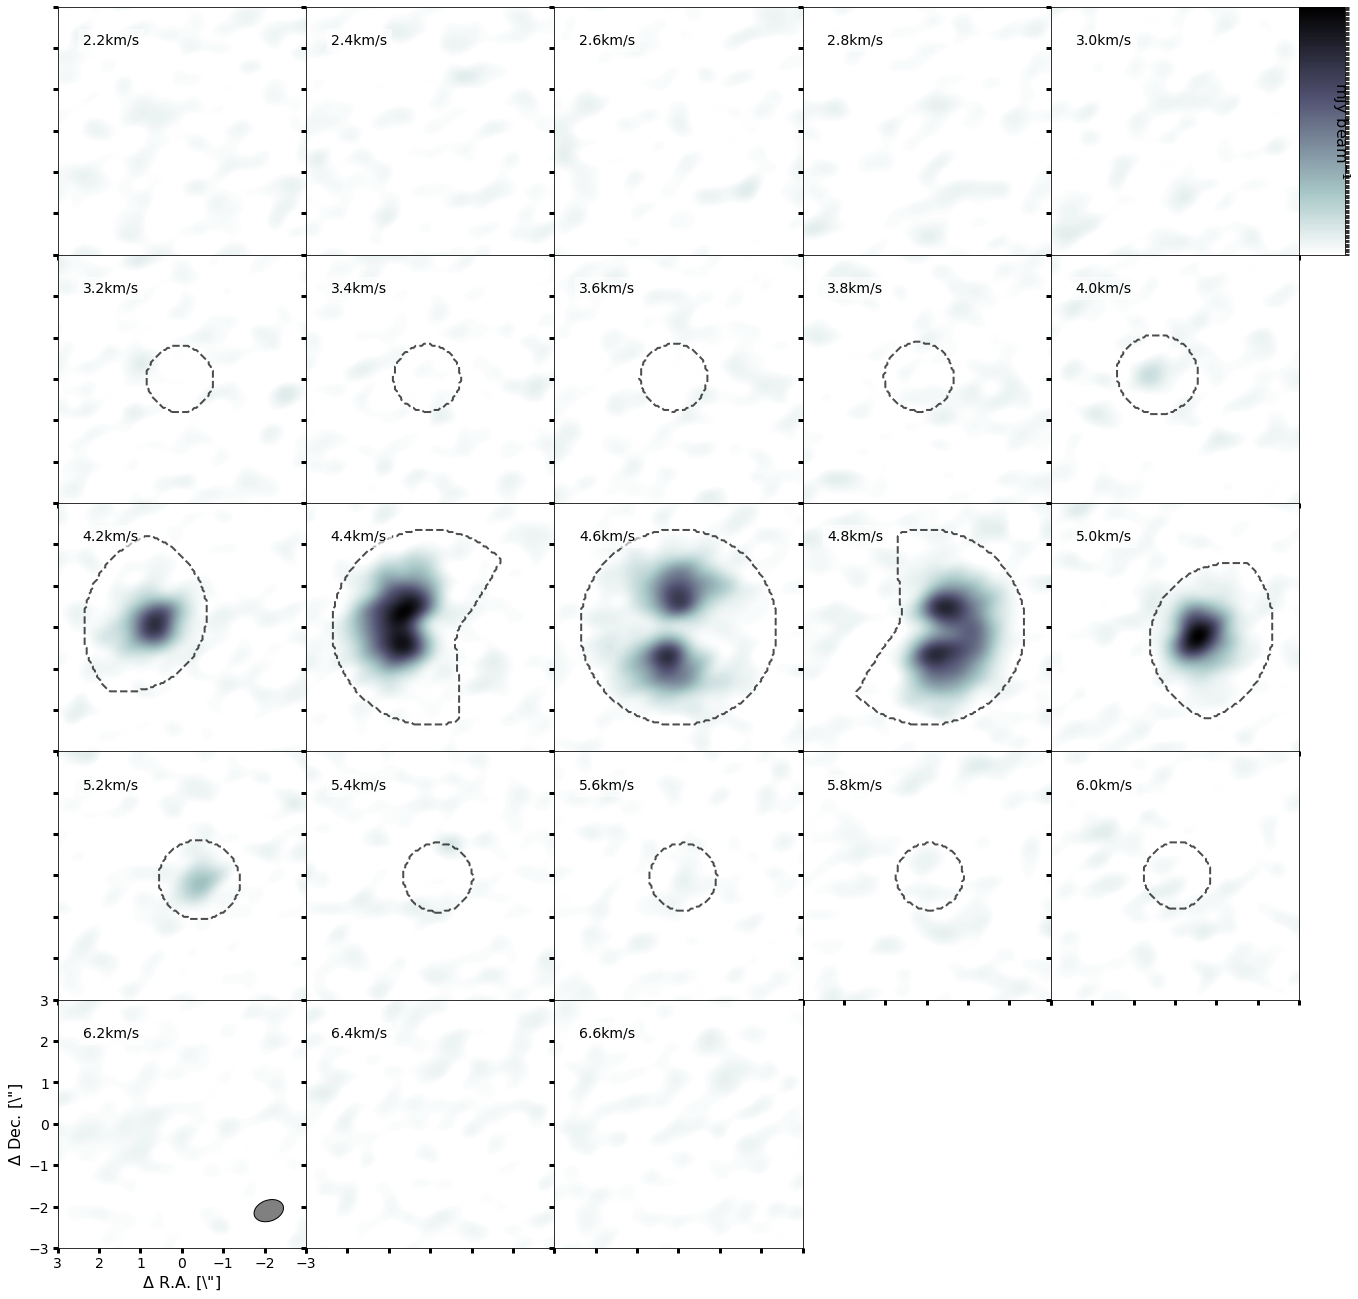

In [16]:
#Set the velocity range of channels to plot (in [km/s])
vrange_kms = [2.2, 6.8]

#Plot the channels
kmset_j1604.plot_product("channels", vrange_kms=vrange_kms, ncol=5)

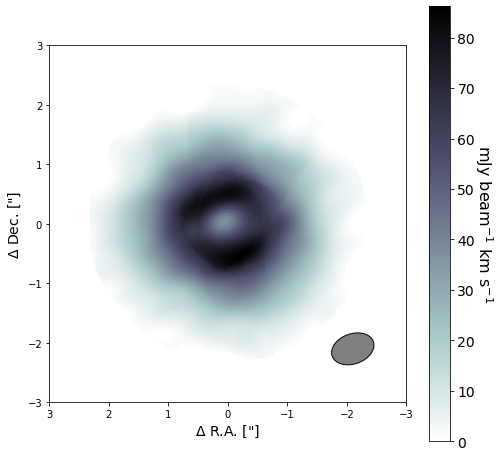

In [17]:
#Plot the mom0
kmset_j1604.plot_product("mom0")

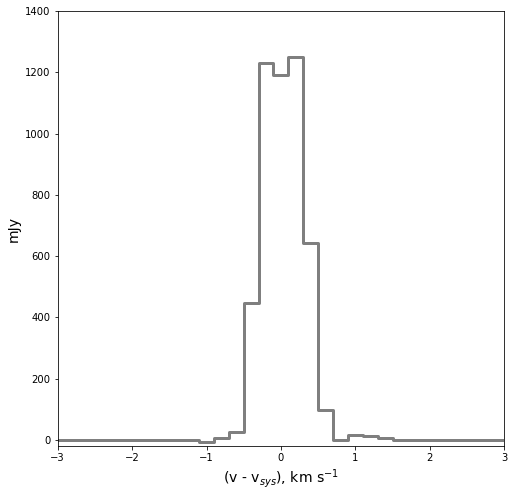

In [18]:
#Plot the spectrum
kmset_j1604.plot_product("spectrum", ylim=[-20, 1400])

Note that these are *simple* plots, just meant to show you what the data looks like.  They are 'somewhat' customizable (in a user-friendly way).  Some of the common $\texttt{matplotlib.pyplot}$ parameters (e.g., linewidth, color, and cmap) can be passed into ***plot_product()*** to spice up these simple plots a bit more.  As always, you can use ***help()*** to get a list of all parameters that you can use:

In [19]:
help(kmset_j1604.plot_product)

Help on method plot_product in module pykepmask.kepmask:

plot_product(prod, dosave=False, savename='testing.png', figsize=(8, 8), title='', ncol=7, xlim=[-3.0, 3.0], ylim=[-3.0, 3.0], color='black', cmap=<matplotlib.colors.LinearSegmentedColormap object at 0x7f81f92cee80>, vmin=0.0, vmax=None, vrange_kms=None, textsize=14, titlesize=16, linewidth=3.0, linestyle='-', alpha=0.5, beamx=0.85, beamy=0.15) method of pykepmask.kepmask.KepMask instance
    METHOD: plot_product
    PURPOSE: Return a plot of the desired image product (e.g., spectrum
      or mom0).
    INPUTS:
      - alpha [float, default=0.5]: Line transparency.  Valid values are from
          0 (transparent) to 1 (opaque).  Used only for spectra.
      - beamx [float, default=0.8]: Relative x-axis location of beam (scaled
          from 0 to 1).  Used only for mom0s and channel maps.
      - beamy [float, default=0.8]: Relative y-axis location of beam (scaled
          from 0 to 1).  Used only for mom0s and channel maps.
  

And if you ever forget the exact keywords you need to access/plot these products, just pass in an invalid string to ***get_product()*** and ***plot_product()*** as applicable.  You'll get a helpful error message, which will tell you the names of all valid products.

In [20]:
#Uncomment the line below to get another helpful error
#kmset_j1604.get_product("morehelpplease")

#Uncomment the line below to get yet another helpful error
#kmset_j1604.plot_product("helpmeheretoo")

### Masks with hyperfine structure

We can also generate Keplerian masks for molecular lines with hyperfine structure - e.g., HCN 3-2.  So let's put everything we've learned so far together.  Our goal is to generate the final masked products for HCN 3-2 observed toward J1100-7619.  To incorporate the hyperfine structure, we simply use the hypfreqs parameter in the ***generate()*** method.  That's the only procedural difference from what we did before.

In [21]:
#Import the kepmask module as km
from pykepmask import kepmask as km
#Import constants from astropy
import astropy.constants as astconst
msun = astconst.M_sun.value #Solar mass [kg]
pc0 = astconst.pc.value #Parsec [m]
au0 = astconst.au.value #AU [m]
#Import pi from numpy
import numpy as np
pi = np.pi

#Declare some values for the disk J1100-7619
mstar = 0.23 *msun #[kg]; Stellar mass
vsys = 4.75 *1E3 #[m/s]; Systemic velocity
dist = 160 *pc0 #[m]; Distance to source
PA = (109) *pi/180.0 #[radians]; Position angle
inc = (21) *pi/180.0 #[radians]; Inclination angle
midx = 200 #[index]; Location along x-axis of midpoint
midy = 200 #[index]; Location along y-axis of midpoint

#Create an instance of KepMask for J1100-7619
kmset_j1100 = km.KepMask(mstar=mstar, vsys=vsys, dist=dist, PA=PA, inc=inc, midx=midx, midy=midy)

#Load in the molecular line data
fitsname = "J1100-7619_HCN32.fits" #This should point to the location+filename of the image cube .fits file
kmset_j1100.extract(fitsname=fitsname)

#Set the radial boundary and beam convolution parameter of the masks
Rmax = 300 *au0 #[m]
beamfactor = 2.5 #[unitless]

#Set the channel indices that will actually have masks.
whichchans = np.arange(40, 90+1, 1) #Set to None to mask all channels

#Set the velocity broadening parameters
V0_ms = 0.22 *1E3 #Prefactor [m/s]
R0_AU = 100.0 #Characteristic radius [AU] - note that this is the sole parameter not in S.I. units!
q0 = 0.3 #Power law - note that this value should be positive (negation is already within the code)



###NOTE THE USE OF THE hypfreqs PARAMETER HERE!
#List the frequencies (in [Hz]) for the hyperfine components you want to include.
#NOTE: The main hyperfine frequency should be listed *first*.
hypfreqs = np.array([265.88643390, 265.88618860, 265.88649990, 265.88489120, 265.88852210]) *1E9 #[Hz]; 5 major components
#Generate the Keplerian masks
kmset_j1100.generate(mask_Rmax=Rmax, hypfreqs=hypfreqs, whichchans=whichchans, V0_ms=V0_ms, R0_AU=R0_AU, q0=q0,
                    beamfactor=beamfactor)
###

/Users/jamila.pegues/Documents/STScI_Fellowship/Research/Modules/repo_kepmask/kepmask/pykepmask/_utilsKep.py:418: RuntimeWarning: divide by zero encountered in true_divide
  azimvelmatr = np.sqrt(G0*mstar/1.0/rposmatr) #Azimuthal velocity
/Users/jamila.pegues/Documents/STScI_Fellowship/Research/Modules/repo_kepmask/kepmask/pykepmask/_utilsKep.py:419: RuntimeWarning: invalid value encountered in true_divide
  velmatr = ((xrotangmatr/1.0/rangmatr)
/Users/jamila.pegues/Documents/STScI_Fellowship/Research/Modules/repo_kepmask/kepmask/pykepmask/_utilsKep.py:444: RuntimeWarning: invalid value encountered in true_divide
  return {"velmatr":velmatr, "rmatr":rposmatr, "y/r":(yrotangmatr/1.0/rangmatr),
/Users/jamila.pegues/Documents/STScI_Fellowship/Research/Modules/repo_kepmask/kepmask/pykepmask/_utilsKep.py:455: RuntimeWarning: divide by zero encountered in power
  deltvmatr = turbpreval*((rmatr/1.0/(r0*au0))**(-1*qval)) #m/s


MASK GENERATION TOOK 1.46S.
MASK GENERATION TOOK 1.45S.
MASK GENERATION TOOK 1.41S.
MASK GENERATION TOOK 1.43S.
MASK GENERATION TOOK 1.42S.


In [22]:
#Print the velocity-integrated flux
intflux = kmset_j1100.get_product("intflux")
print("The velocity-integrated flux is {0:.2f} mJy km/s.".format(intflux*1E3/1.0E3))

The velocity-integrated flux is 1651.54 mJy km/s.


/Users/jamila.pegues/Documents/STScI_Fellowship/Research/Modules/repo_kepmask/kepmask/pykepmask/_utilsAstro.py:452: UserWarning: No contour levels were found within the data range.
  plothere.contour(x_arr, y_arr,
/Users/jamila.pegues/Documents/STScI_Fellowship/Research/Modules/repo_kepmask/kepmask/pykepmask/_utilsAstro.py:475: MatplotlibDeprecationWarning: 
The ax attribute was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  plothere.set_xlim(maphere.ax.get_xlim()[::-1]) #Makes x-axis descend


<Figure size 576x576 with 0 Axes>

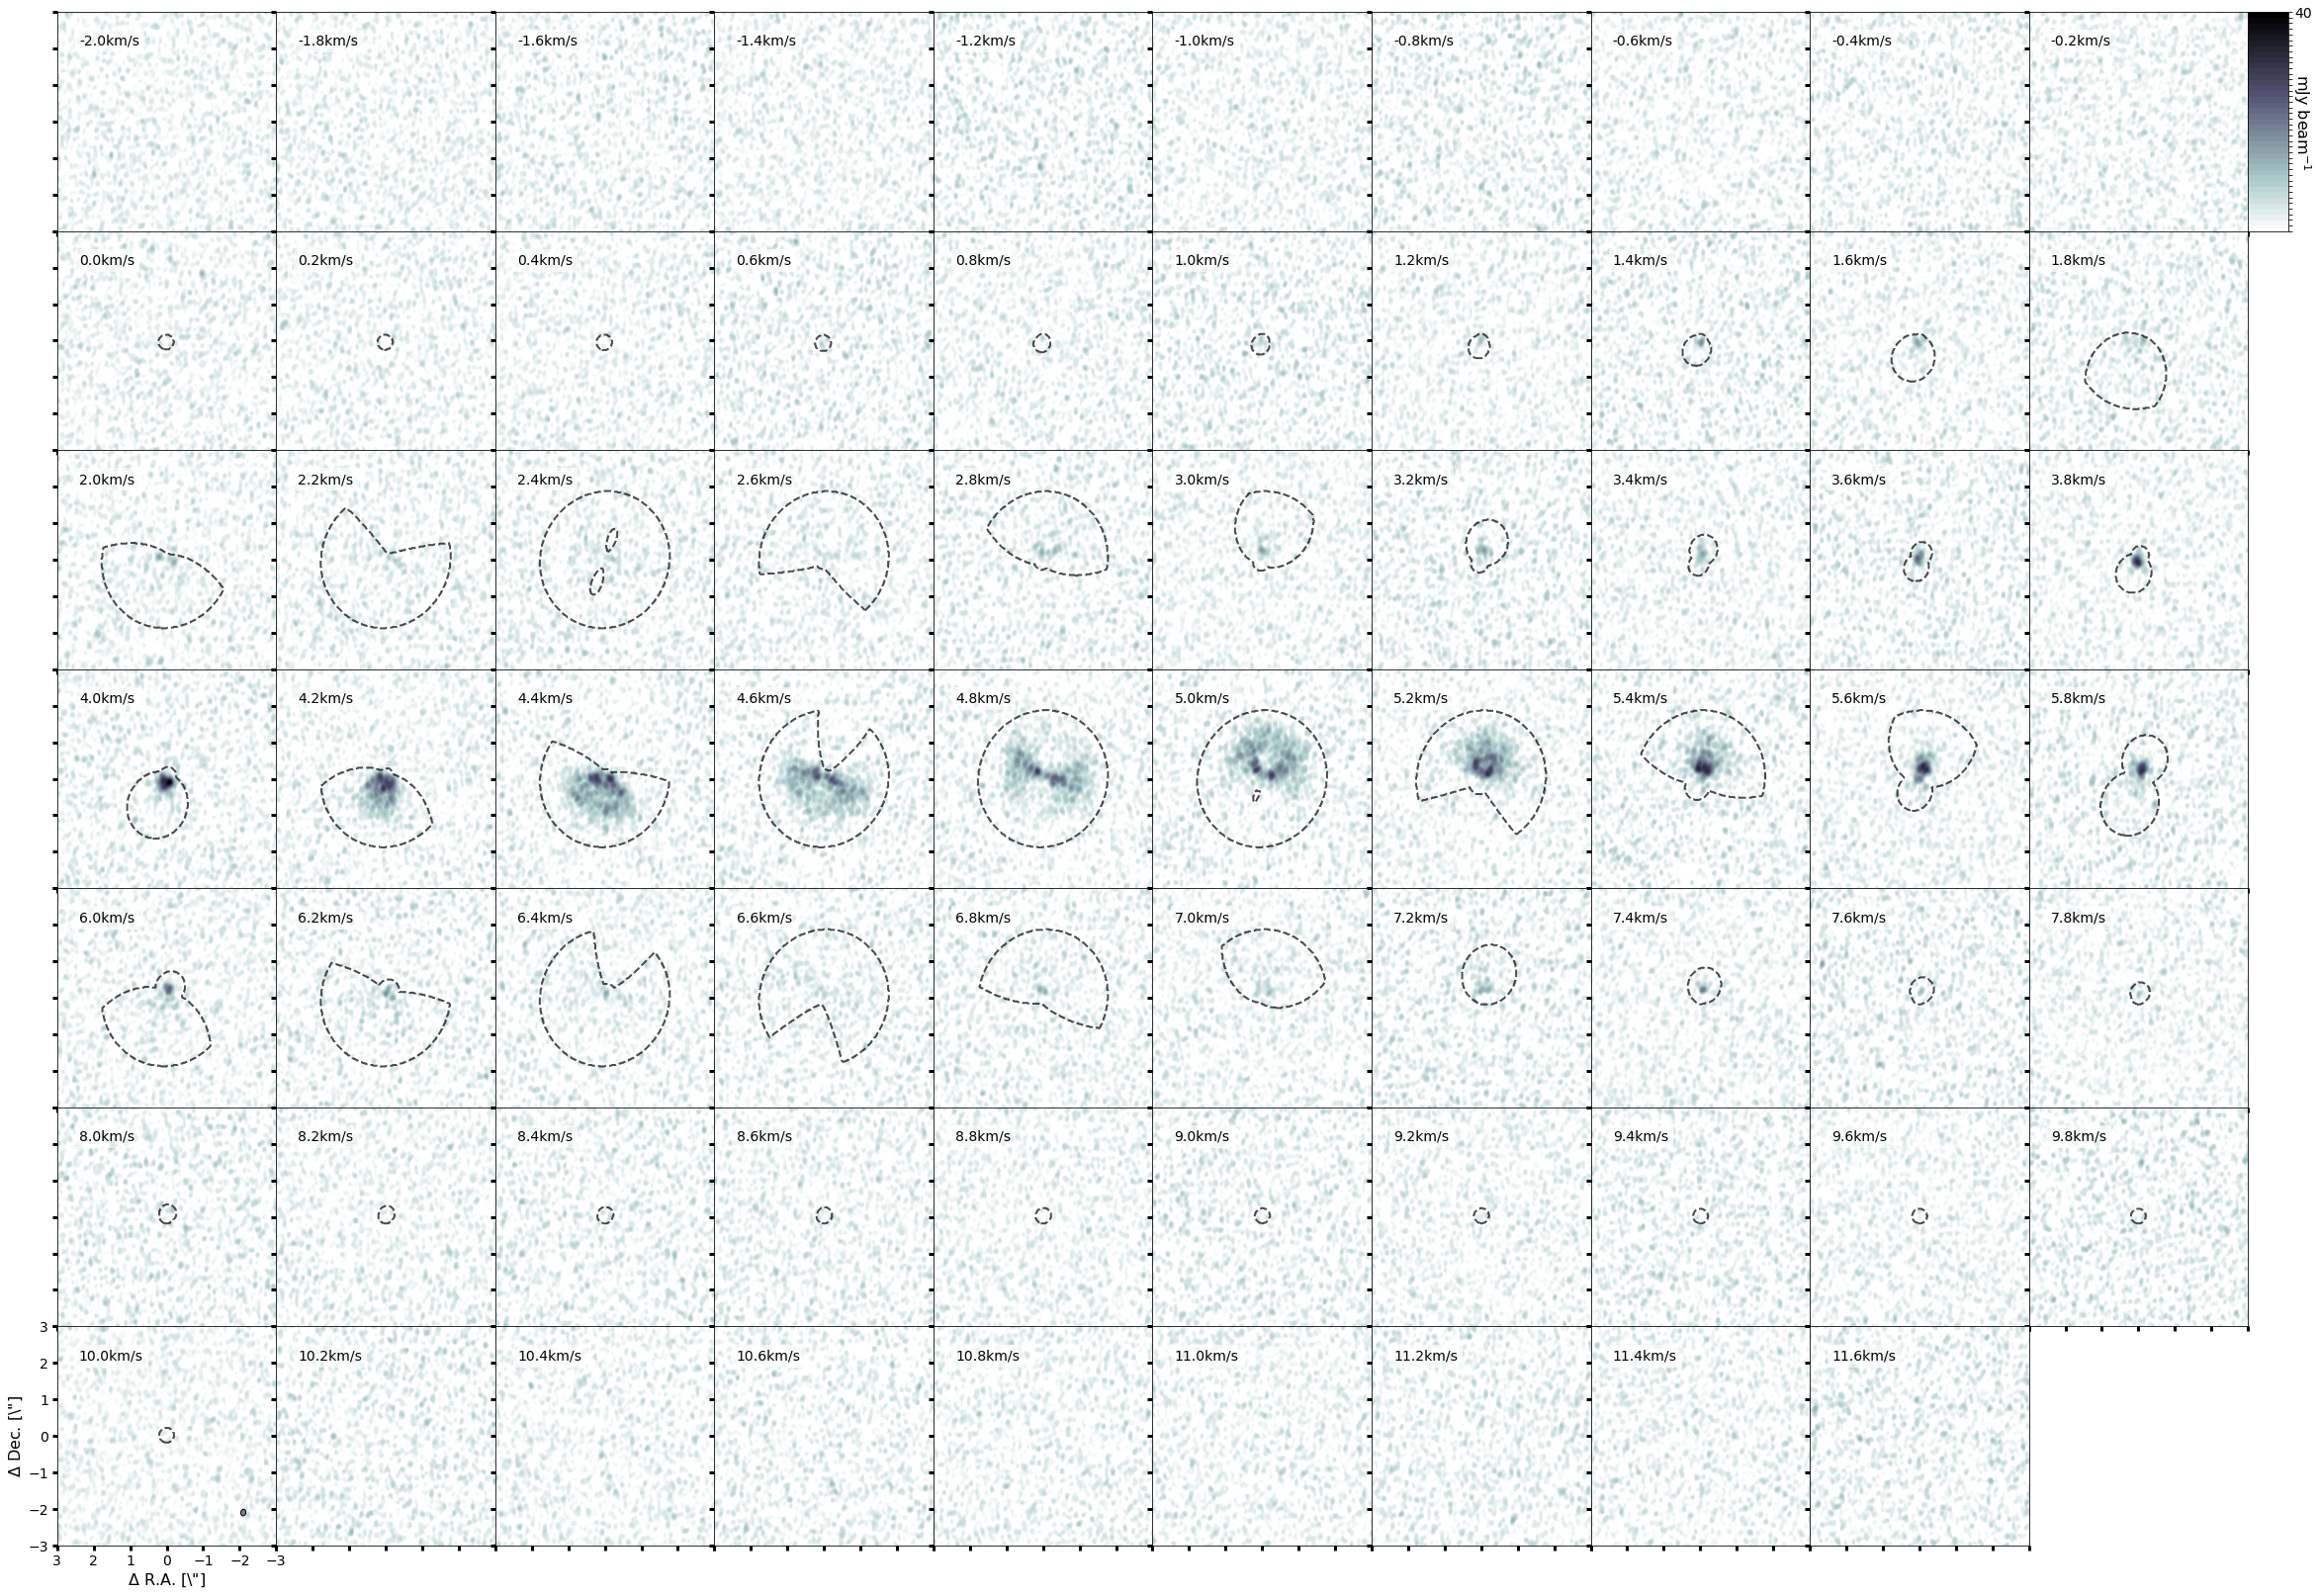

In [23]:
#Set the velocity range of channels to plot (in [km/s])
vrange_kms = [-2.0, 11.8]

#Plot the channels
kmset_j1100.plot_product("channels", vrange_kms=vrange_kms, ncol=10)

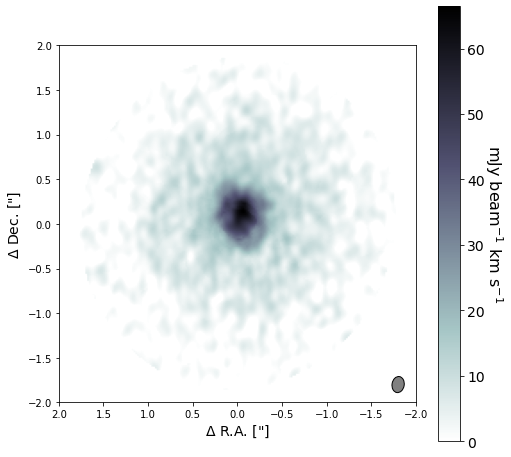

In [24]:
#Plot the mom0
kmset_j1100.plot_product("mom0", xlim=[-2, 2], ylim=[-2, 2], beamx=0.95, beamy=0.05)

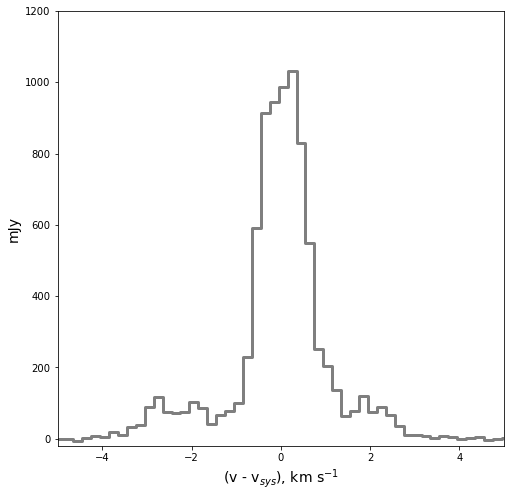

In [25]:
#Plot the spectrum
kmset_j1100.plot_product("spectrum", xlim=[-5, 5], ylim=[-20, 1200])

### Generating Keplerian masks for a synthetic image cube

We can also create Keplerian masks for a completely synthetic image cube, by passing in a set of disk and image parameters.  We can do this via the ***synthesize()*** method.  Let's start by making some fake disk and image data:

In [37]:
#Set some synthetic image parameters
nchan = 55 #Number of channels in synthetic image
RAlen = 200 #X-axis length of synthetic image
RAstart = 15 *pi/180 #[rad]; Start of RA array
RAwidth = (0.1/3600) *pi/180 #[rad]; Spacing of RA array
DEClen = 100 #Y-axis length of synthetic image
DECstart = 10 *pi/180 #[rad]; Start of RA array
DECwidth = (0.05/3600) *pi/180 #[rad]; Spacing of DEC array
velstart = 2.5 *1E3 #[m/s]; Start of velocity array
velwidth = 0.1 *1E3 #[m/s]; Spacing of the velocity array
bmaj = (0.50/3600) *pi/180 #[rad]; Full major axis of beam
bmin = (0.35/3600) *pi/180 #[rad]; Full minor axis of beam
bpa = (60) *pi/180 #[rad]; Position angle of beam

#Set some synthetic disk parameters
mstar = 1 *msun #[kg]; Stellar mass
vsys = 5.5 *1E3 #[m/s]; Systemic velocity
dist = 100 *pc0 #[m]; Distance to source
PA = (100) *pi/180.0 #[radians]; Position angle
inc = (10) *pi/180.0 #[radians]; Inclination angle
midx = RAlen * 3 // 4 #[index]; Location along x-axis of midpoint
midy = DEClen // 2 #[index]; Location along y-axis of midpoint

#Set some synthetic mask parameters
Rmax = 150 *au0 #[m]
beamfactor = 5 #[unitless]
whichchans = None #np.arange(15, 40+1, 1) #Set to None to mask all channels
V0_ms = 0.15 *1E3 #Prefactor [m/s]
R0_AU = 50.0 #Characteristic radius [AU] - note that this is the sole parameter not in S.I. units!
q0 = 0.15 #Power law - note that this value should be positive (negation is already within the code)

Now let's create a Keplerian mask for the synthetic image:

In [38]:
#Create an instance of KepMask for a generic disk around a solar mass star
kmset_synth = km.KepMask(mstar=mstar, vsys=vsys, dist=dist,
                            PA=PA, inc=inc, midx=midx, midy=midy)

#Feed in the synthetic image details
kmset_synth.synthesize(nchan=nchan, ralen=RAlen, rastart=RAstart, rawidth=RAwidth,
                       declen=DEClen, decstart=DECstart, decwidth=DECwidth,
                       velstart=velstart, velwidth=velwidth,
                       bmaj=bmaj, bmin=bmin, bpa=bpa)

#Generate the Keplerian masks in the synthetic image
kmset_synth.generate(mask_Rmax=Rmax, whichchans=whichchans, V0_ms=V0_ms, R0_AU=R0_AU, q0=q0, beamfactor=beamfactor)

MASK GENERATION TOOK 0.07S.


And we can plot the Keplerian mask within the synthetic image using the same channel map plotter as before:

<Figure size 576x576 with 0 Axes>

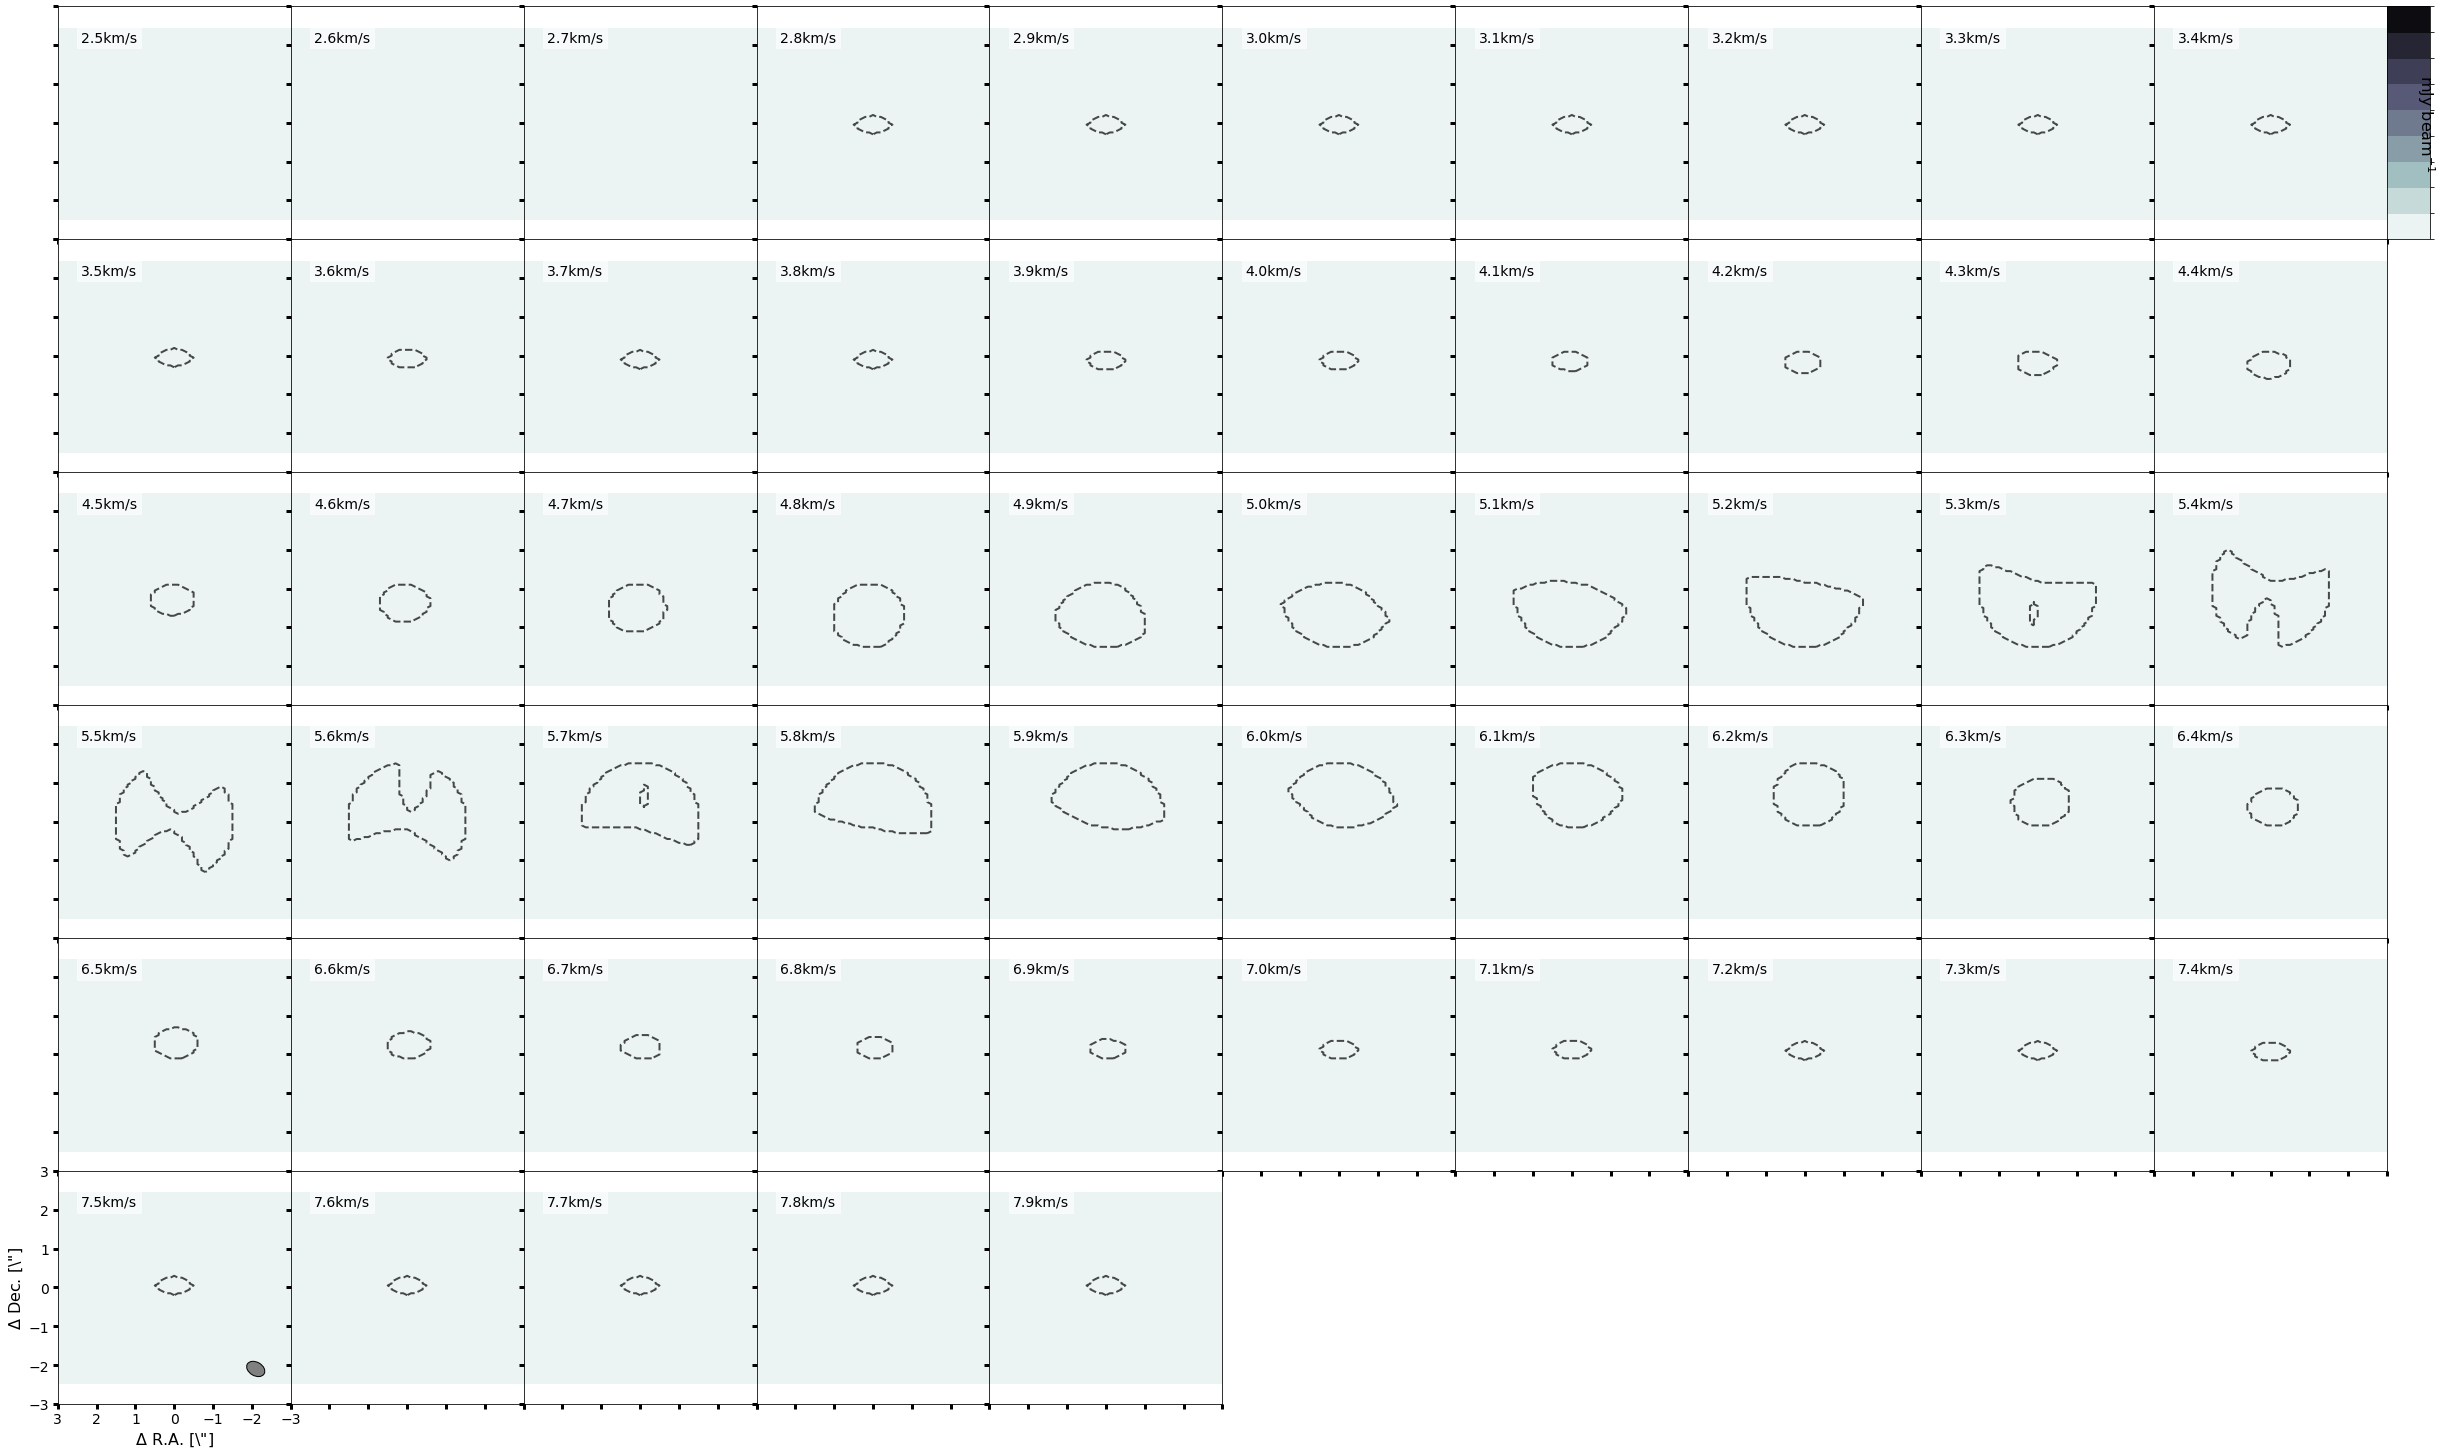

In [39]:
#Plot the masks in the synthetic channels
vrange_kms = [-4, 10]
kmset_synth.plot_product("channels", vrange_kms=vrange_kms, ncol=10)

Finally, we can save the masks using the same procedure as before:

In [29]:
#Extract the masks
masks = kmset_synth.get_product("masks") #Fetch the masks into a variable

#Save the masks
maskname = "masks_synth.npy" #Name for the saved mask file
np.save(maskname, masks) #Save the masks under the given filename

And that's all she wrote, folks!

If you have any questions/concerns with pykepmask, suggestions for improvements/new features, and/or any issues that you've found, ***please*** do let us know on [the GitHub page](https://github.com/jpegues/kepmask)!

In [30]:
print("This tutorial has completed successfully.")

This tutorial has completed successfully.
